# Домашнее задание 2. Преобразование данных

Цель этого задания -- преобразовать имеющиеся атрибуты пользователей в признаки так, чтобы полученная матрица признаков была пригодна для подачи в алгоритм кластеризации. Этап конструирования признаков -- самый важный и обычно самый долгий. К нему возвращаются много раз на протяжении решения задачи анализа данных.

Кроме библиотек, использованных в первом задании, нам понадобятся следующие библиотеки:
1. [scikit-learn](http://scikit-learn.org/stable/) -- библиотека, реализующая множество алгоритмов машинного обучения и сопутствующих алгоритмов

In [217]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.preprocessing as sp
import csv
import re
import dateutil

np.set_printoptions(linewidth=150, precision=3, suppress=True)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [218]:
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m") if pd.notnull(date_str) and date_str else None
df_users = pd.read_csv("hw1_out.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

Далее необходимо ввести новые признаки. Для каждого пользователя предлагается ввести следующие признаки:
- name_words - количество слов в имени
- screen_name_length - количество символов в псевдониме
- description_length - длина описания
- created_year - год создания аккаунта
- country_code - код страны
- verified - предлагается перевести в тип int

(2 балла)

In [219]:
def create_new_features(df_users, features):
    # Introduce new features
    new_features = ["name_words", "screen_name_length", "description_length", "created_year", "country_code", "verified"]
    # Add new_features to features
    # place your code here
    features += new_features
    
    # Calculate new features and place them into data frame
    # place tour code here
    name_words, screen_name_length, description_length, created_year, country_code, verified = [], [], [], [], [], []
    for name in df_users["name"]:
        name_words.append(len(name.split()))
    df_users["name_words"] = pd.Series(name_words)
    
    
    for screen_name in df_users["screen_name"]:
        if pd.isnull(screen_name):
            screen_name_length.append(0)
        else:
            screen_name_length.append(len(screen_name))
    df_users["screen_name_length"] = pd.Series(screen_name_length)
    
   
    for description in df_users["description"]:
        if pd.isnull(description):
            description_length.append(0)
        else:
            description_length.append(len(description))
    df_users["description_length"] = pd.Series(description_length)
    
    for date in df_users["created_at"]:
        if pd.isnull(date):
            creadted_year.append(0)
        else:
            created_year.append(date.year)
    df_users["created_year"] = pd.Series(created_year)
    
    country_id = 0
    country_code = []
    codes = {}
    for country in df_users["country"]:
        if pd.isnull(country):
            country_code.append(0)
        else:
            if not (country in codes):
                country_id += 1
                codes[country] = country_id    
            country_code.append(codes[country])
    df_users["country_code"] = pd.Series(country_code)
    for verification in df_users["verified"]:
        if not verification:
            verified.append(0)
        else:
            verified.append(1)
    df_users["verified"] = verified
    return df_users, features


In [220]:
features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
df_users, features = create_new_features(df_users, features)
x = df_users[pd.notnull(df_users.cls)][features].values
y = df_users[pd.notnull(df_users.cls)]["cls"].values

Посмотрим, являются ли какие-либо из выбранных признаков сильно скоррелированными. Для этого посчитаем матрицу корреляций и выберем те пары признаков, абсолютное значения коэффициента корреляции между которыми больше 0.2. Необходимо реализовать функцию find_correlated_features, в которой нужно рассчитать коэффициенты корелляции и вывести те, которые больше 0.2. Подсказка: предлагается найти необходимую функцию в библиотеке np и реализовать find_correlated_features с использованием не более 5 строк кода (включая заголовок функции). (2 балла)

In [221]:
def find_correlated_features(x, features):
    # replace this code to find really correlated features
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            if (i < j) and abs(np.corrcoef(x[:,i], x[:,j])[1,0]) > 0.2:
                print "Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, np.corrcoef(x[:,i], x[:,j])[1,0])



In [222]:
find_correlated_features(x, features)

Correlated features: lat + lon -> -0.64
Correlated features: followers_count + friends_count -> 0.39
Correlated features: followers_count + listed_count -> 0.69
Correlated features: followers_count + verified -> 0.36
Correlated features: friends_count + listed_count -> 0.38
Correlated features: statuses_count + favourites_count -> 0.27
Correlated features: statuses_count + listed_count -> 0.20
Correlated features: listed_count + verified -> 0.35


Выделилось 3 группы признаков:
1. Основанные на географии:  "lat", "lon", "country_code"
2. Основанные на социальной активности:  "verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"
3. Остальные:  "name_words", "screen_name_length", "description_length"

Построим взаимные распределения пар признаков в каждой из групп, а также гистограмму значений каждого из признаков с учетом целевой переменной.

In [223]:
def plot_two_features_scatter(x_i, x_j, y):
    
    # Set colors and plot scatter
    # your code here
    pos_x, pos_y, neg_x, neg_y = [], [], [], []
    
    for i in range(len(x_i)):
        if y[i] == 1:
            pos_x.append(x_i[i])
            pos_y.append(x_j[i])
        elif y[i] == 0:
            neg_x.append(x_i[i])
            neg_y.append(x_j[i])
    #для сохранения пропорциональности будем печатать порциями по size_portion человек(иначе зеленые точки перекроют
    #красные)
    size_portion = 100
    len_pos = int(len(pos_x) / size_portion)
    len_neg = int(len(neg_x) / size_portion)
    for portion in range(size_portion):
        pl.scatter(pos_x[portion * len_pos: (portion + 1) * len_pos], pos_y[portion * len_pos: (portion + 1) * len_pos],\
                   c = 'red', alpha=0.7)
        pl.scatter(neg_x[portion * len_neg: (portion + 1) * len_neg], neg_y[portion * len_neg: (portion + 1) * len_neg],\
                   c = 'green', alpha=0.7)
    
def plot_feature_histogram(x_i, y):
    
    # Compute positive and negative histograms
    # your code here
    
    # Plot stacked barplots
    # your code here
    list_pos, list_neg = [], []
    
    for i in range(len(y)):
        if y[i] == 1:
            list_pos.append(x_i[i])
        elif y[i] == 0:
            list_neg.append(x_i[i])
    pl.hist([list_pos, list_neg], color = ['red', 'green'], alpha=0.7)


def plot_dataset(x, y, features):
    # Tune your plot if necessary
    # your code here
    pl.rcParams['figure.figsize'] = (35, 35)
    pl.rcParams.update({'font.size': 20})
        
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            
            # Tune your plot if necessary (for example set labels)
            # your code here
            pl.subplot(len(features), len(features), len(features) * i + j + 1)
            
            pl.gca().axes.get_xaxis().set_ticklabels([])
            pl.gca().axes.get_yaxis().set_ticklabels([])
            
            if i == 0:
                pl.gca().xaxis.set_label_position('top')
                pl.gca().set_xlabel(feature_j)
            if j == 0:
                pl.ylabel(feature_i)
            # Do actual plotting
            if i != j:
                plot_two_features_scatter(x[:, j], x[:, i], y)            
            else:
                plot_feature_histogram(x[:, i], y)
    
    pl.show()

Построим попарные распределения географических признаков ([подсказка](http://stroykova.github.io/sphera/l2_1.png)).

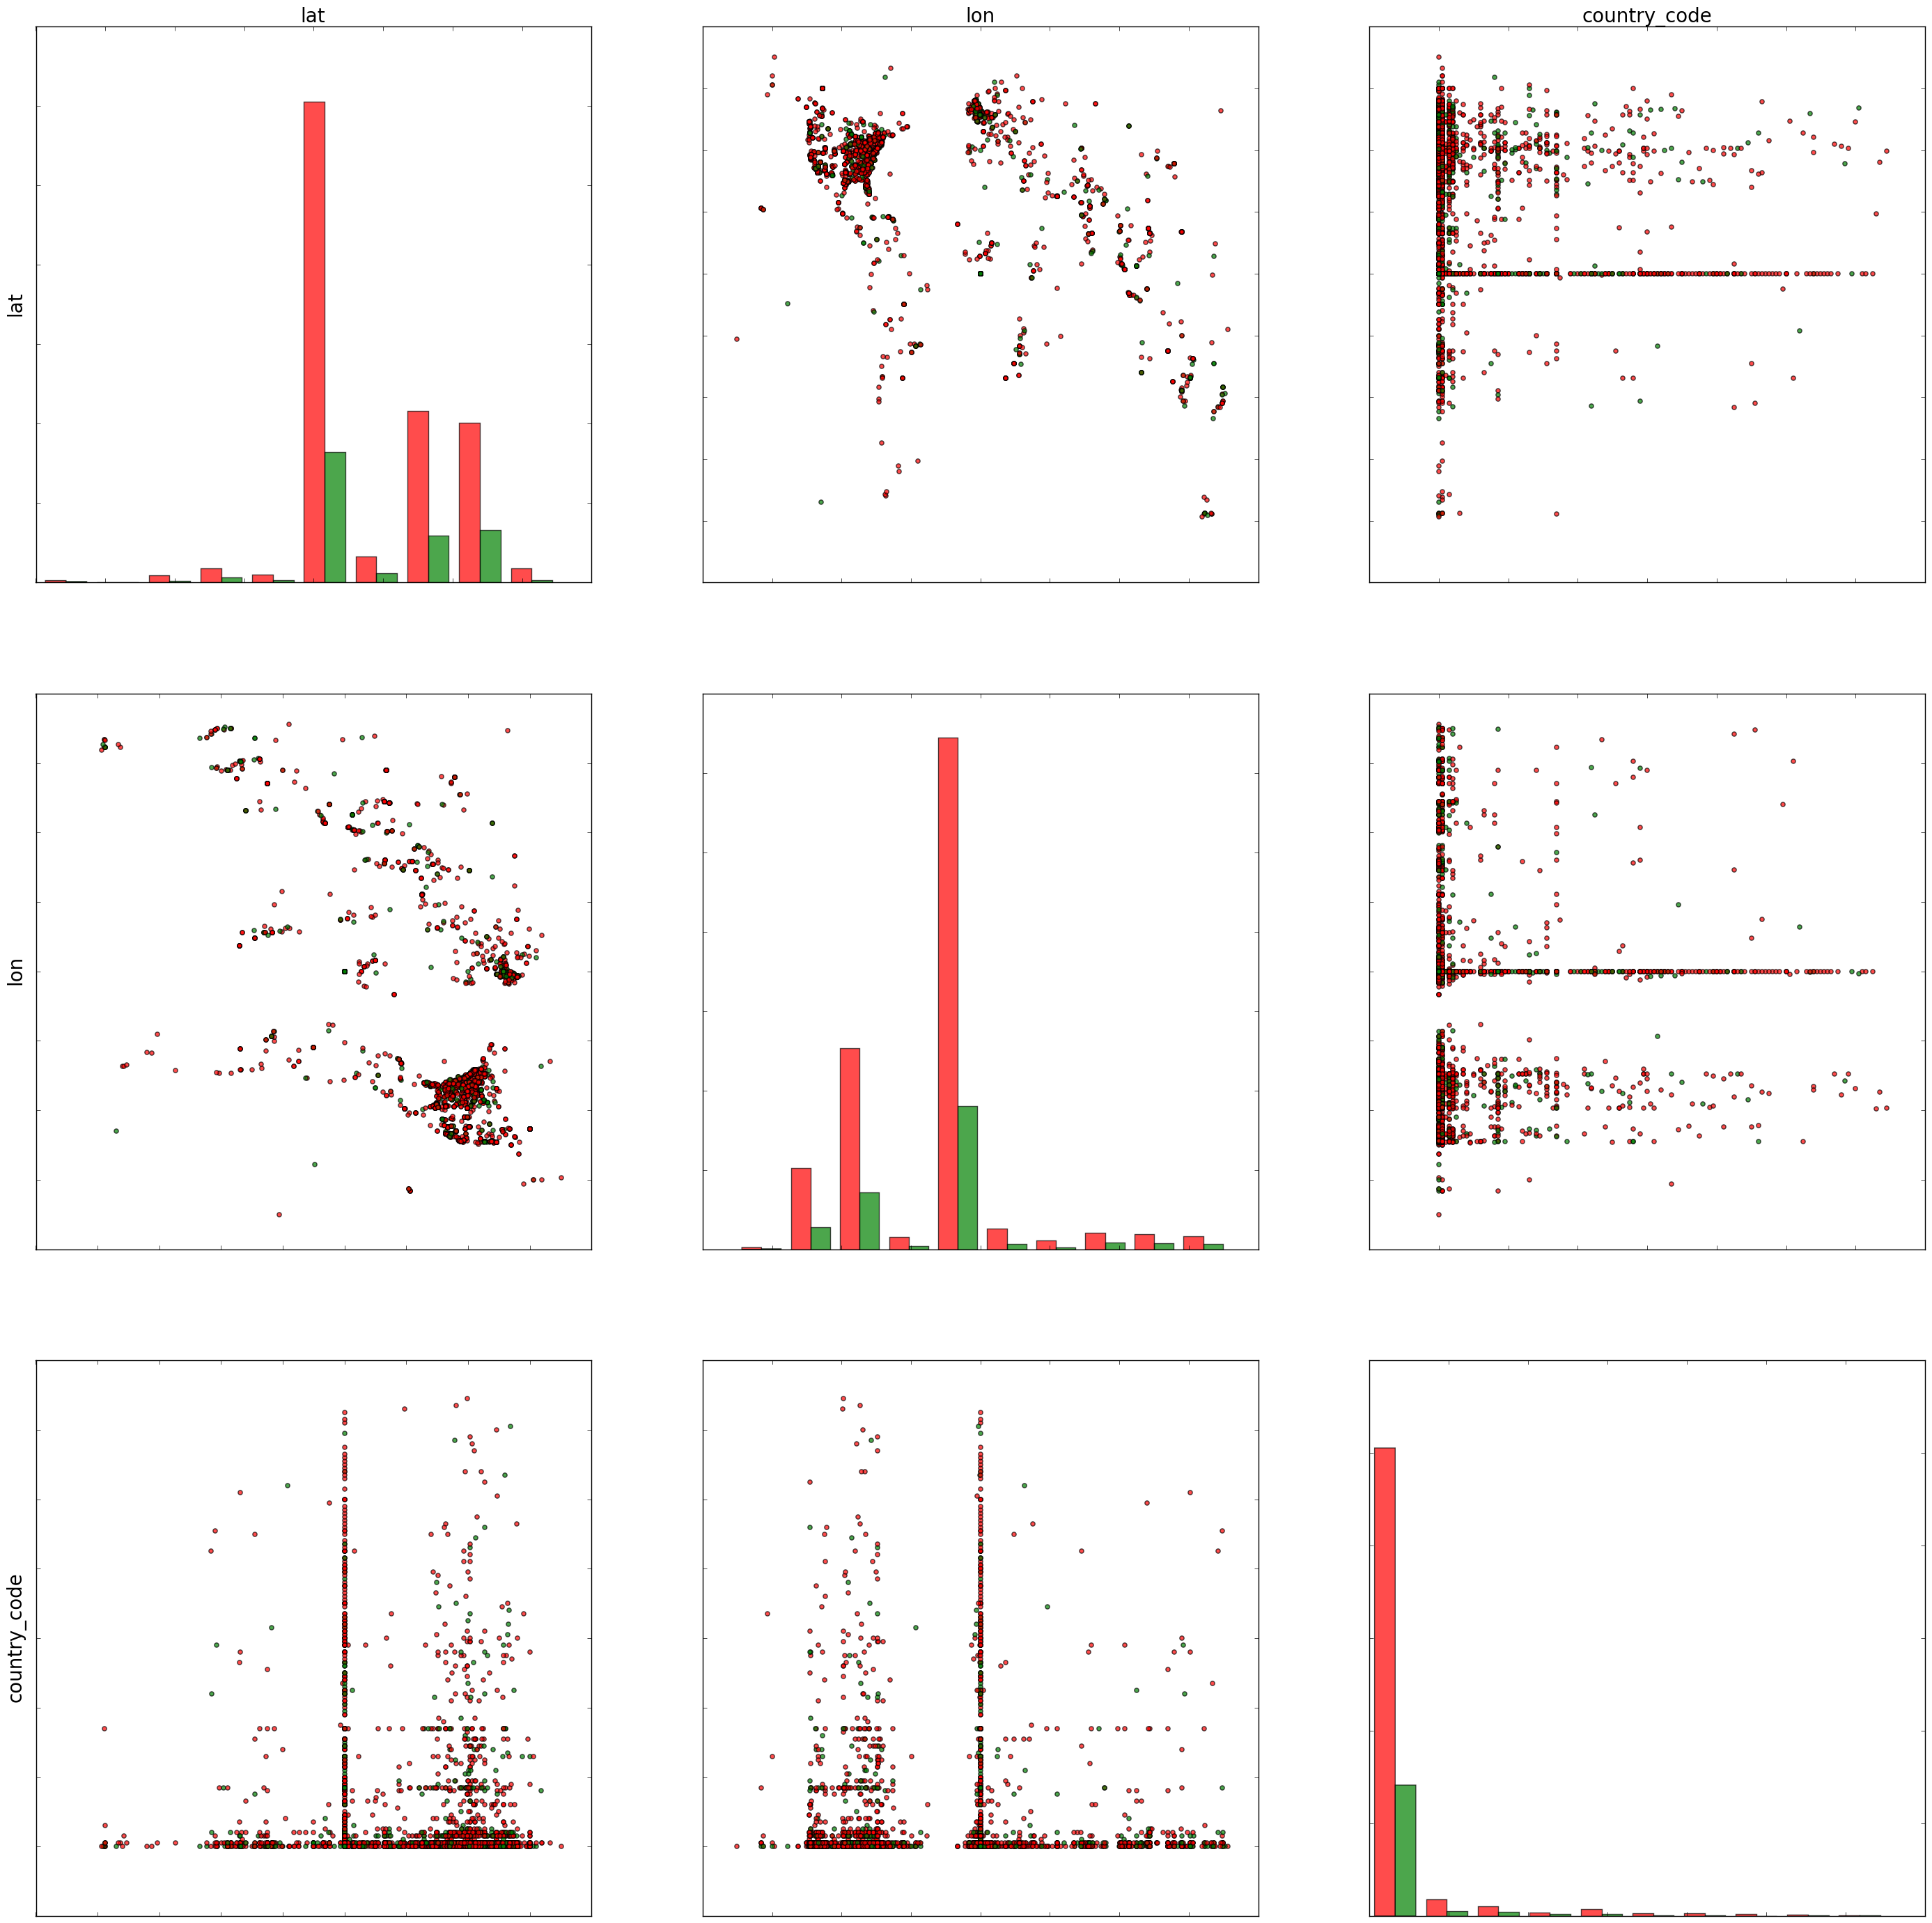

In [224]:
geo_features_new = ["lat", "lon", "country_code"]
#По-моему, здесь была опечатка, аналогично в нижних ячейках.
#geo_features = [f for f in geo_features_new if f in features]
geo_features = [f for f in features if f in geo_features_new]

geo_feature_ind = [i for i, f in enumerate(features) if f in geo_features]

plot_dataset(x[:, geo_feature_ind], y, geo_features)

Четко видны очертания карты и то, что большинство пользователей происходят из небольшого набора стран. Если принять во внимание конечную цель -- кластеризацию пользователей -- логично предположить, что использование географических признаков для описания пользователя может оказаться не очень полезным. Причина в том, что эти признаки четко пространственно разделены (как минимум, океанами и морями). Поэтому мы рискуем вместо "интересной" кластеризации получить просто кластеры, которые будут представлять разные страны. В дальнейшем мы исключим географические признаки из рассмотрения при кластеризации пользователей.

Далее построим попарные распределения социальных признаков ([подсказка](http://stroykova.github.io/sphera/l2_2.png)).

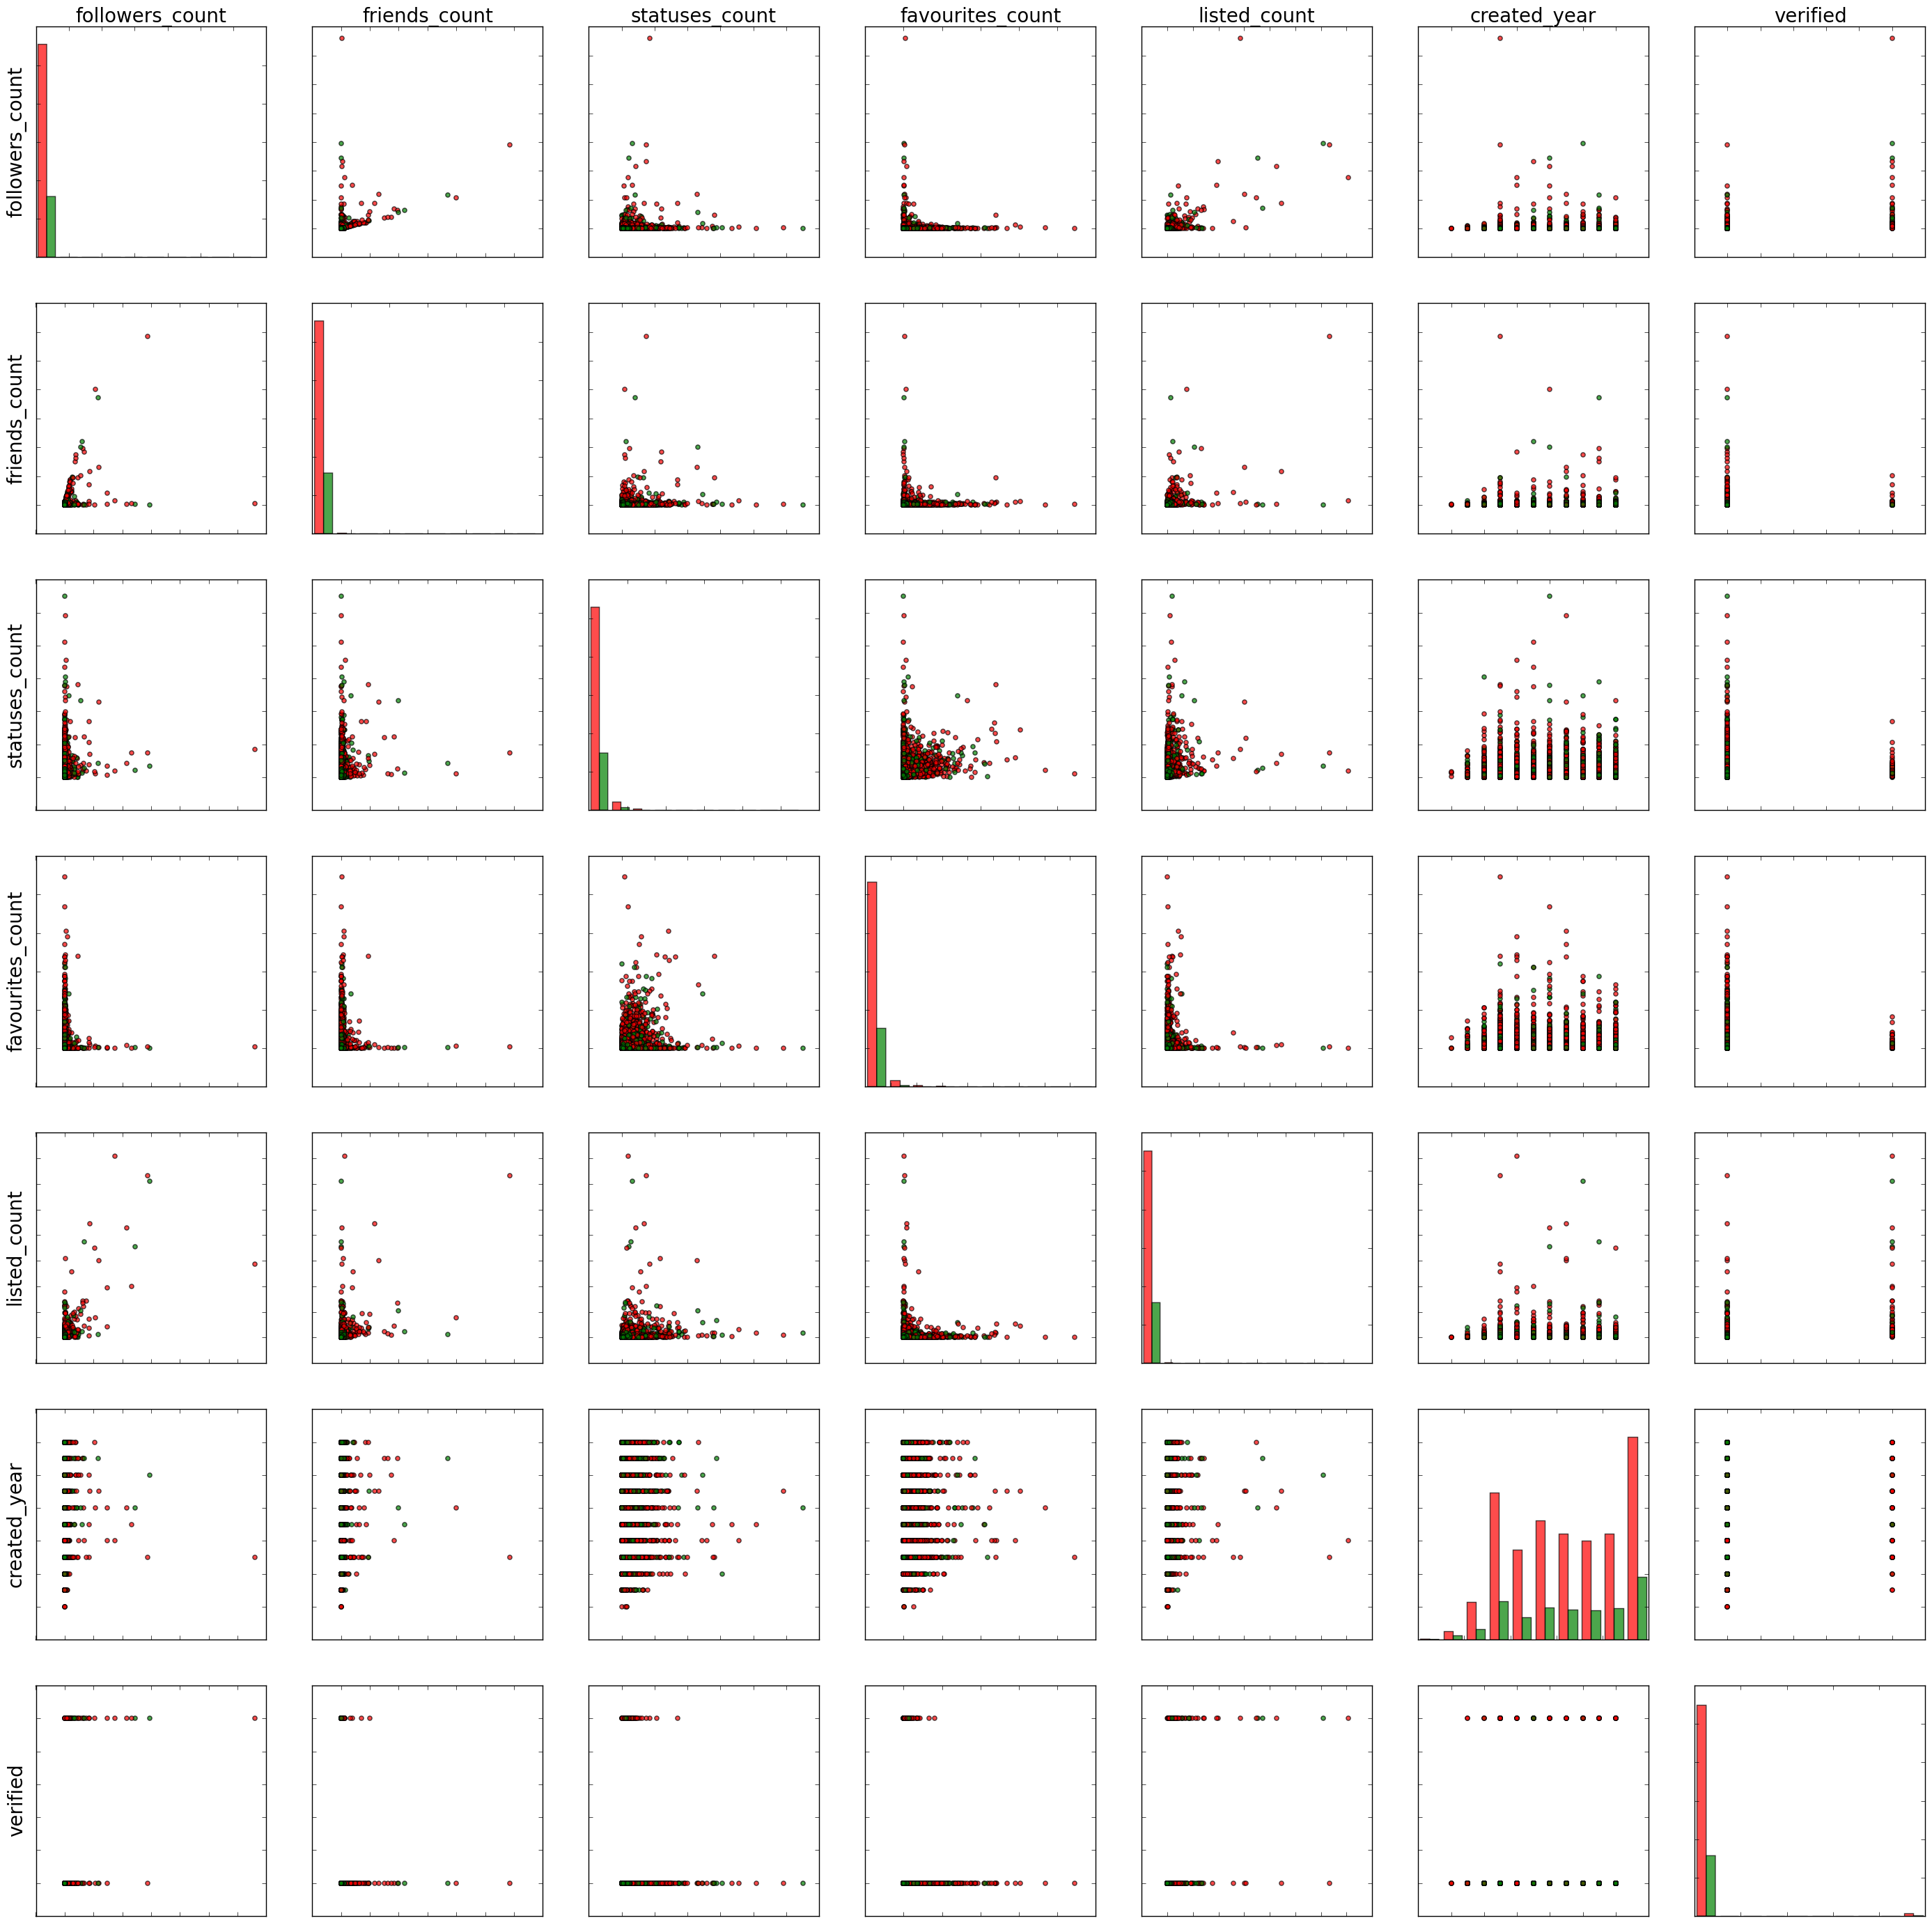

In [225]:
social_features_new = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]
#social_features = [f for f in social_features_new if f in features]
social_features = [f for f in features if f in social_features_new]
social_feature_ind = [i for i, f in enumerate(features) if f in social_features] 
plot_dataset(x[:, social_feature_ind], y, social_features)

Из графиков видно, что признаки "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count" сильно смещены в сторону небольших значений. В таком случае удобно сделать логарифмическое преобразрвание этих признаков, то есть применить к их значениям $x_{ij}$ функцию $\log(1 + x_{ij})$. Сделаем это и построим новые распределения ([подсказка](http://stroykova.github.io/sphera/l2_3.png)). Необходимо реализовать функцию log_transform_features, которая выполняет указанное логарифмическое преобразование. (2 балла)

In [226]:
def log_transform_features(data, features, transformed_features):
    # place your code here
    # transform selected features with log function
    idx = [i for i, f in enumerate(features) if f in transformed_features]
    data[:, idx] = np.log(1 + data[:, idx])
    return data

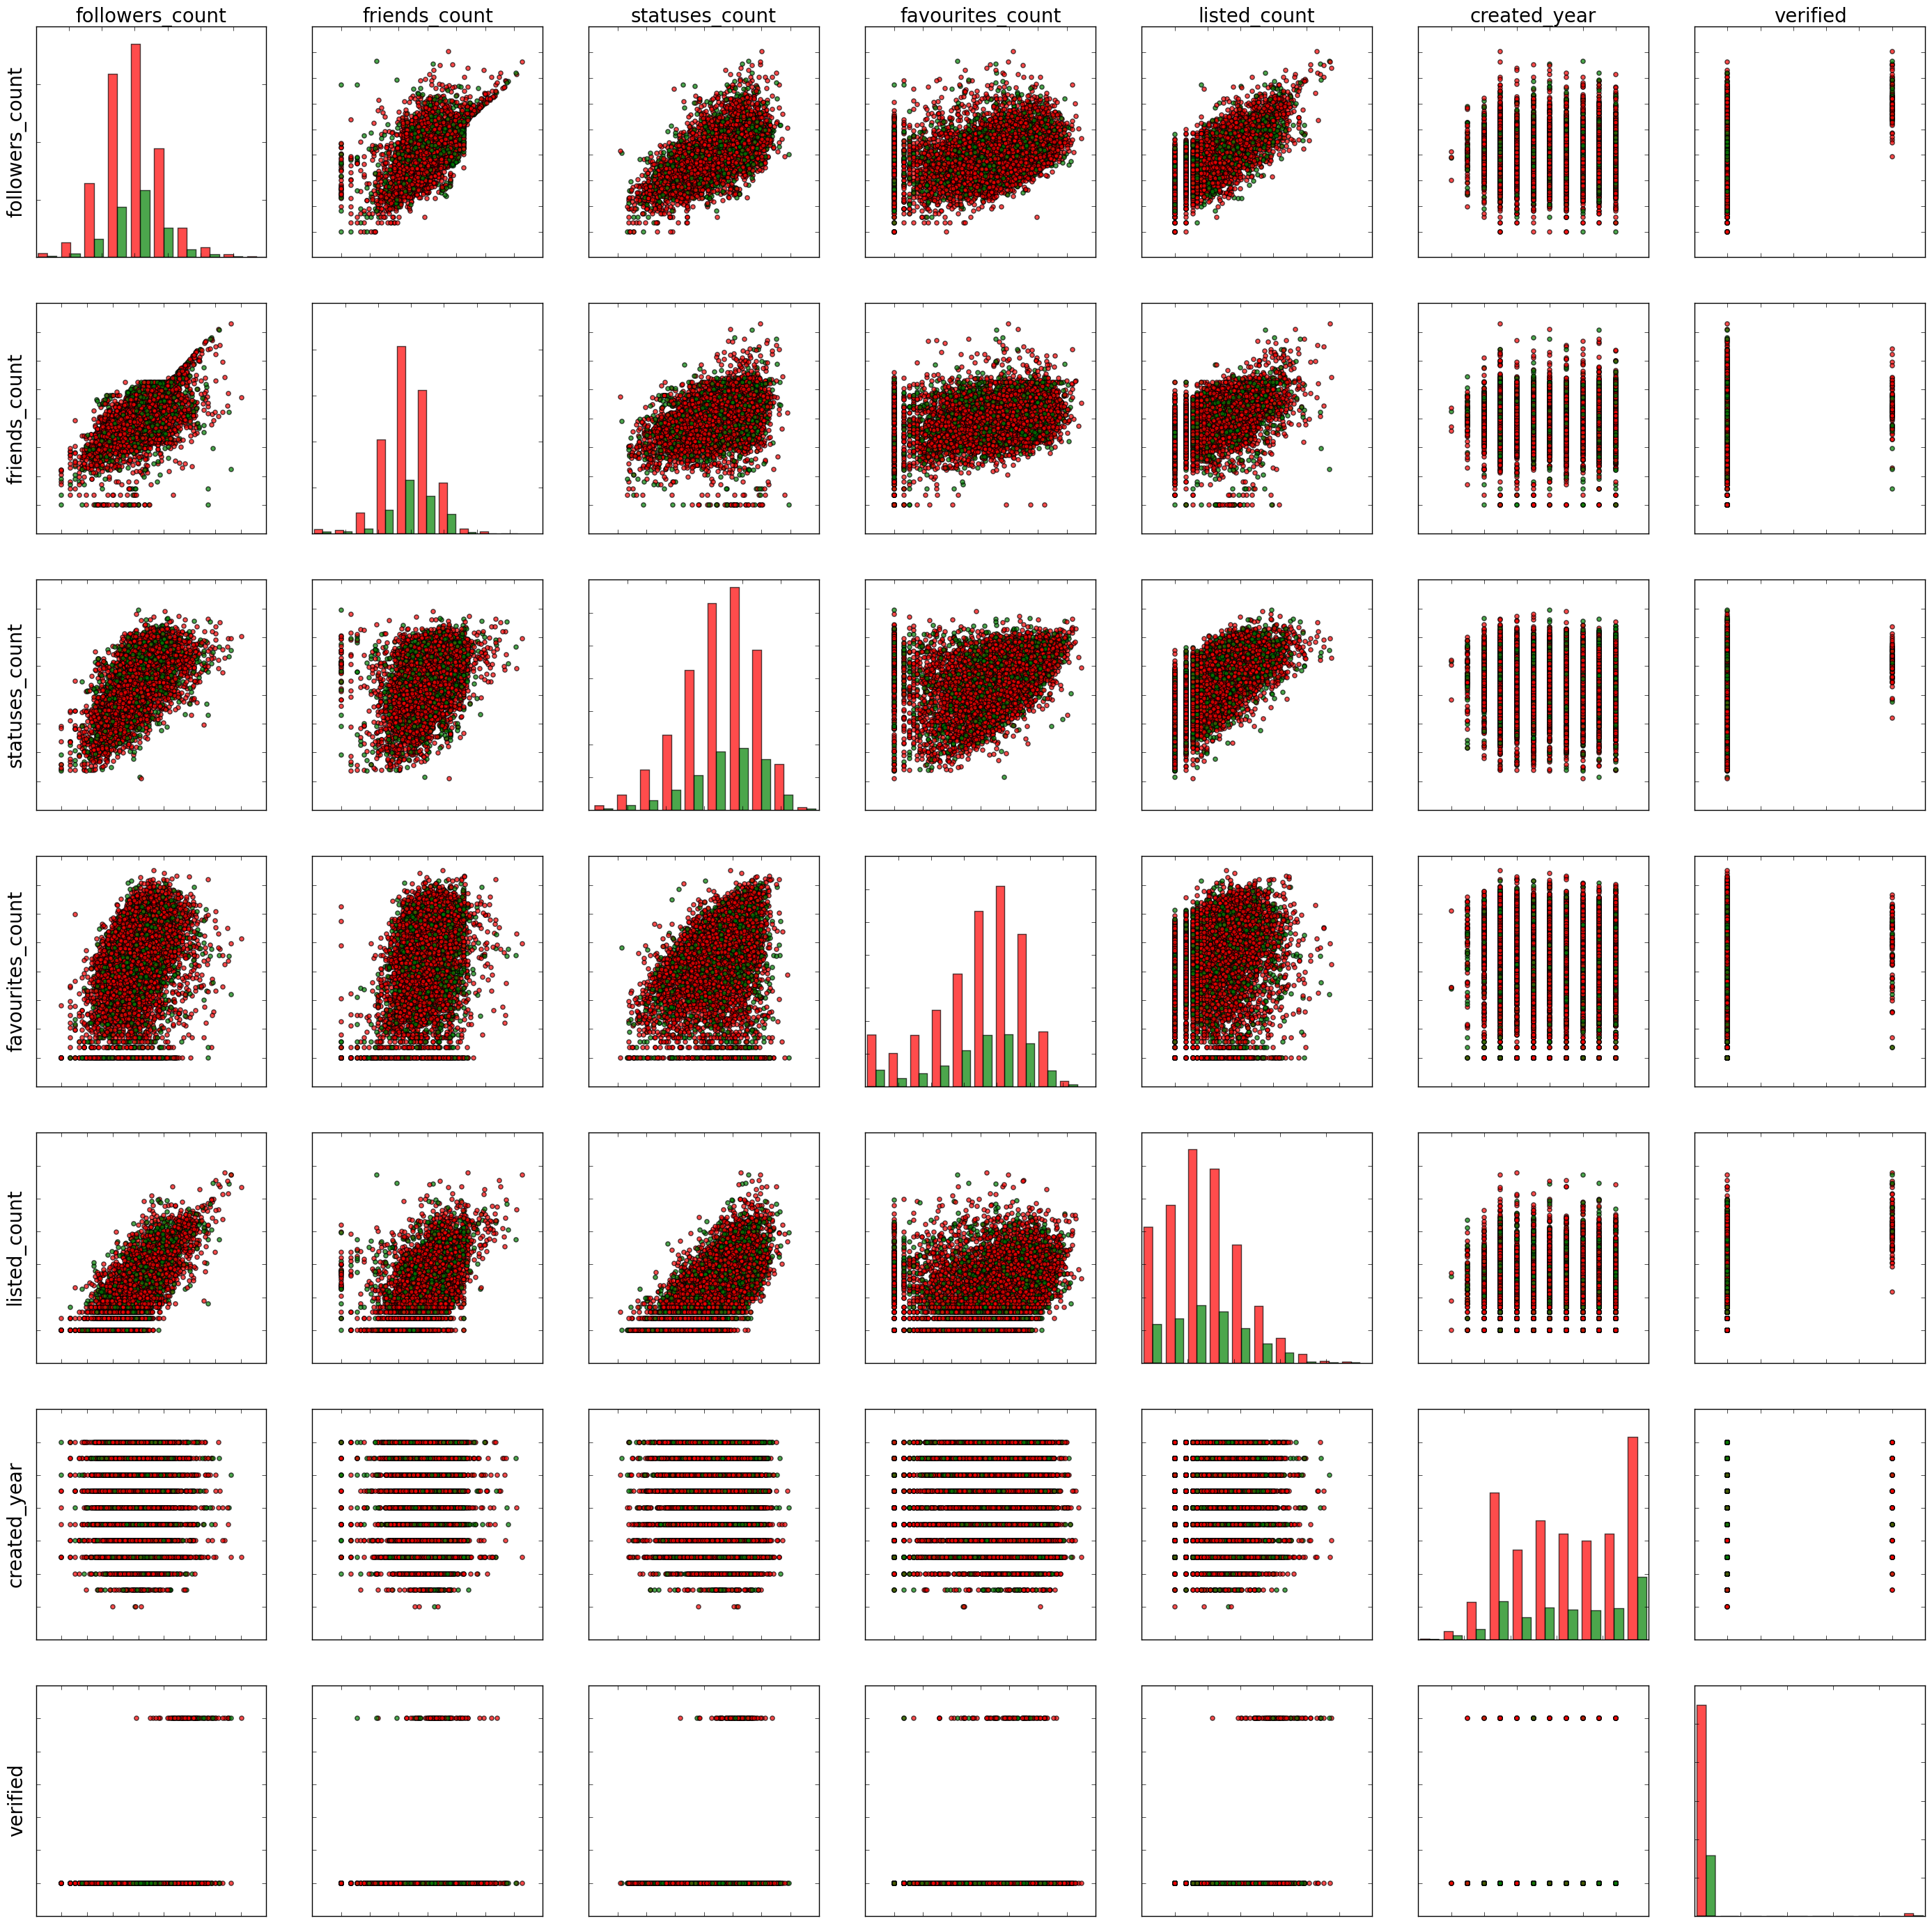

In [227]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
x = log_transform_features(x, features, transformed_features)

# Re-plot features
plot_dataset(x[:, social_feature_ind], y, social_features)

Сразу бросается в глаза, что признак "verified" сильно смещен -- верифицированных пользователей очень мало. Более того, все верифицированные пользователи имеют много фолловеров, поэтому часть информации о верификации дублируется в признаке "followers_count". По этой причине в дальнейшем не будем рассматривать признак "verified".

После того как мы с помощью логрифмического преобразования избавились от сильной скошенности признаков, можно наблюдать некоторые интересные зависимости. Например, пользователи, имеющие много фолловеров, обязательно имеют много статусов. Следовательно, чтобы стать популярным, обязательно нужно много писать. Анализ других зависимостей остается как упражнение.

Наконец построим попарные распределения остальных признаков ([подсказка](http://stroykova.github.io/sphera/l2_4.png)).

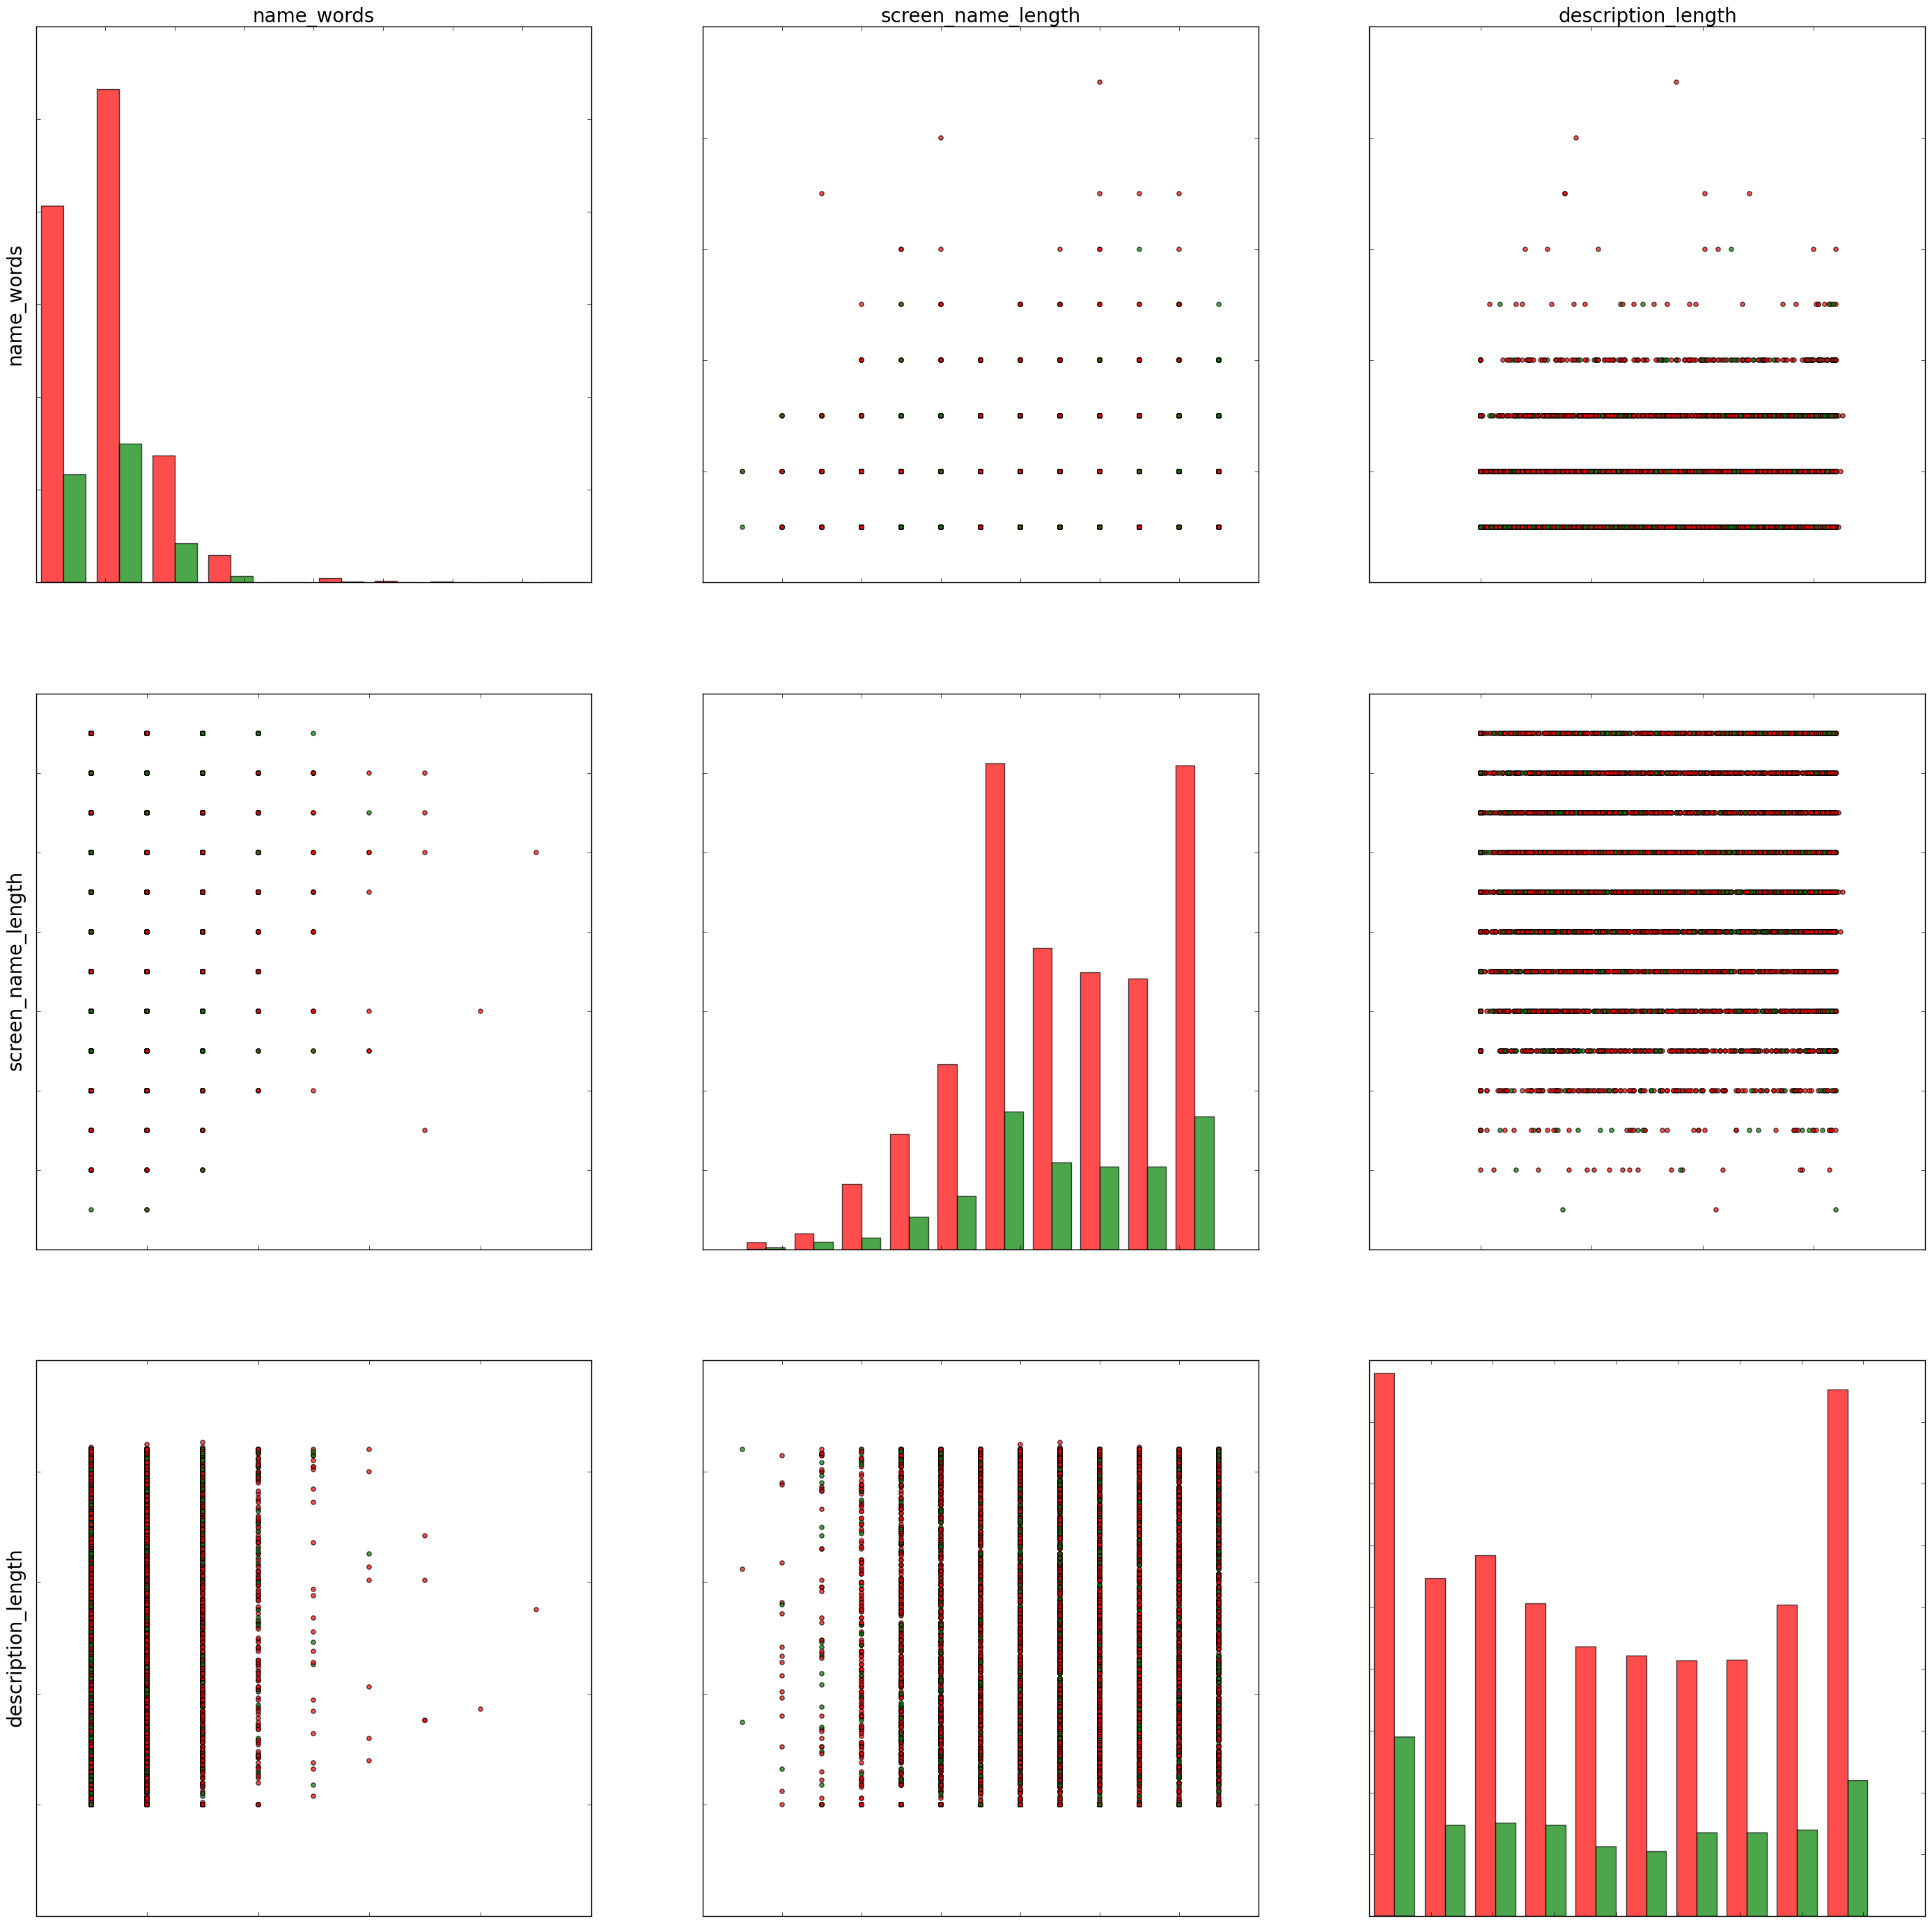

In [228]:
other_features_new = ["name_words", "screen_name_length", "description_length"]
#other_features = [f for f in other_features_new if f in features]
other_features = [f for f in features if f in other_features_new]
other_feature_ind = [i for i, f in enumerate(features) if f in other_features]
plot_dataset(x[:, other_feature_ind], y, other_features)

Итак после первичной обработки данных мы имеем 9 числовых признаков, каждый из которых распределен в некотором своем интервале. Для того, чтобы ни один признак не получил перевеса при кластеризации, нормализуем данные так, что каждый признак распределен на отрезке $[0, 1]$. 

In [229]:
selected_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", 
                     "listed_count", "created_year", "name_words", "screen_name_length", "description_length"]

x_1 = df_users[selected_features].values
y = df_users["cls"].values

# x_1 = x[:, selected_features_ind]
# Replace nan with 0-s
# Is there a smarter way?
x_1[np.isnan(x_1)] = 0
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

Упакуем полученную матрицу в pandas DataFrame и сохраним в файл "hw2_out.csv". В следующем задании мы будем кластеризовать пользователей на оновании этих данных.

In [230]:
df_out = pd.DataFrame(data=x_new, index=df_users["uid"], columns=[f for f in selected_features])
df_out.to_csv("hw2_out.csv", sep="\t")